# Collaboration and Competition

In [12]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from ddpg_agent import Agent
from collections import deque
from utils import plot_scores, save_checkpoint
from torchsummary import summary
from model import Actor, Critic

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
env = UnityEnvironment(file_name="Tennis.app", no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 1. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 2. Watch a Smart Agent

In [5]:
agent = Agent(
    num_agents=len(env_info.agents),
    state_size=state_size,
    action_size=action_size,
    random_seed=2)

load_path = 'results/checkpoint_solved.pth'
cuda = torch.cuda.is_available()

if cuda:
    checkpoint = torch.load(load_path)
else:
    checkpoint = torch.load(load_path,
                        map_location=lambda storage, loc: storage)
    
agent.actor_local.load_state_dict(checkpoint['actor_state_dict'])
agent.critic_local.load_state_dict(checkpoint['critic_state_dict'])

env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)

In [6]:
for i in range(1, 6):
    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += rewards
        states = next_states
        if np.any(dones):
            break
        print('\rScore (max over agents) from episode {}: {}'.format(i, np.max(scores)), end="")
env.close()

Score (max over agents) from episode 5: 2.58000003919005476

### 3. Plotting

In [9]:
max_scores = {'max_scores': checkpoint['scores']}
max_scores = pd.DataFrame(max_scores)
avg_scores = max_scores.rolling(window=100).mean()
avg_scores.fillna(0, inplace=True)

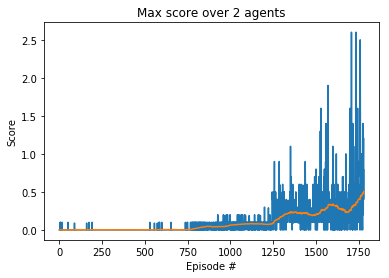

In [15]:
fig = plt.figure()
plt.plot(np.arange(1, len(checkpoint['scores']) + 1), checkpoint['scores'])
plt.plot(np.arange(1, len(checkpoint['scores']) + 1), avg_scores)
plt.title(f"Max score over {len(env_info.agents)} agents")
plt.ylabel("Score")
plt.xlabel("Episode #")
plt.savefig("results/max_scores.png")
plt.show()
plt.close()

In [20]:
avg_scores.tail()

,max_scores
1774,0.488
1775,0.484
1776,0.491
1777,0.493
1778,0.505


In [10]:
summary(agent.actor_local, input_size=(state_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           6,400
       BatchNorm1d-2                  [-1, 256]             512
            Linear-3                  [-1, 128]          32,896
       BatchNorm1d-4                  [-1, 128]             256
            Linear-5                    [-1, 2]             258
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [11]:
summary(agent.critic_local, input_size=[
    (state_size,), (action_size,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           6,400
       BatchNorm1d-2                  [-1, 256]             512
            Linear-3                  [-1, 128]          33,152
            Linear-4                    [-1, 1]             129
Total params: 40,193
Trainable params: 40,193
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------
